# Modelos

En este notebook vamos a retomar el uso de dos dat sets con los cuales deseamos resolver los siguientes problemas:

* Banknotes:
  Deseamos que dadas ciertas caracteristicas de una imagen de un billete, crear un modelo que sea capaz de identificar si un billete es falso o no. Para ello tenemos como datos:

  * La varianza de la imagen transformada de wavelet
  * La asimetría de la imagen transformada por wavelet
  * La curtosis de la imagen transformada de wavelet
  * La entropía de la imagen.

* Occupancy: 
  Deseamos que dadas unas caracteristicas de un billete, crear un modelo que sea capaz de identificar identifica si hay personas o no dentro de un cuarto, para ello tenemos. Para ello tenemos como datos:

  * Fecha y hora en que se tomó la medición
  * Temperatura en grados Celsius
  * Humedad relativa en porcentaje (%)
  * Luz en lux
  * CO2 en partes por millón (ppm)
  * Razón de humedad en kg de vapor de agua por kg de aire

Ambos de estos problemas son de clasificación, por lo que vamos a implementar:

  *   SVM
  *   KNN
  *   Regresión Logistica
  *   Perceptron 

Para evaluar el desempeño de estos modelos, compararemos su rendimiento al variar algunos hiperparámetros y los compararemos entre sí. Para lograr esto, realizaremos validación cruzada con el objetivo de garantizar que nuestros modelos generalicen correctamente y no sufran de sobreajuste.

### Procesamiento de datos y carga de librerías

En esta parte vamos a cargar los datos y las librerias que vamos a usar en este Notebook 

### Librerías 

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

### Base de datos 1 (Bank notes)

Descargamos y procesamos los datos. 

In [ ]:
# Cargamos y organizamos el dataset 1
data_bank = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', header=None)
data_bank.columns = ["variance", "skewness", "curtosis", "entropy", "class"]

# Remplazamos los 0 por -1 para la SVM
data_bank["class"] = data_bank["class"].replace([0],-1)
# Separamos los atributos de las etiquetas
# Atributos 
X_data_bank = data_bank[["variance", "skewness", "curtosis", "entropy"]]
#Etiquetas
y_data_bank = data_bank["class"]

### Base de datos 2 (Occupancy)

Descargamos y procesamos los datos. 

In [ ]:
#Funciones auxiliares
import urllib
import zipfile

# Descargamos y descomprimos los datos
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip"
extract_dir = "occupancy"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir) 

In [ ]:
# Como los datos están separados de una vez para
# entrenar y hacer testing del modelo, es necesario 
# crear varios dataframes

def occupancy_df_process(path):
  data = pd.read_csv(path, sep=",", 
            names=["col","date","Temperature","Humidity",
                   "Light","CO2","HumidityRatio","Occupancy"])[1:]

  data = data.drop(["col"],axis=1)
  #ya no usamos date, pero pues el código está lindo 
  data['date'] = data['date'].apply(lambda x: pd.to_datetime(x).to_julian_date())
  data["Light"] = data["Light"].astype(float)
  data["Temperature"] = data["Temperature"].astype(float)
  data["Humidity"] = data["Humidity"].astype(float)
  data["CO2"] = data["CO2"].astype(float)
  data["HumidityRatio"] = data["HumidityRatio"].astype(float)
  data["Occupancy"] = data["Occupancy"].astype(float)


  # Remplazamos los 0 por -1 para la SVM
  data["Occupancy"] = data["Occupancy"].replace([0],-1)

  # Etiquetas
  X_data = data[["Temperature","Humidity",
                   "Light","CO2","HumidityRatio"]]
  # Atributos
  Y_data = data["Occupancy"]
  return X_data, Y_data

occupancy_train_X , occupancy_train_Y = occupancy_df_process("occupancy/datatraining.txt")
occupancy_test_X , occupancy_test_Y = occupancy_df_process("occupancy/datatest.txt")
occupancy_test2_X , occupancy_test2_Y = occupancy_df_process("occupancy/datatest2.txt")

#Creamos un dataframe unico
occupancy_X = pd.concat([occupancy_train_X,occupancy_test_X, occupancy_test2_X])
occupancy_Y = pd.concat([occupancy_train_Y, occupancy_test_Y, occupancy_test2_Y])

In [ ]:
occupancy_X.dtypes

Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
dtype: object

## Perceptron

Es un algoritmo que toma varias entradas numéricas, las combina ponderándolas con pesos y las pasa por una función de activación para producir una salida binaria. Se utiliza principalmente en problemas de clasificación binaria, donde busca separar dos clases de datos mediante una línea o hiperplano en un espacio multidimensional

### Base de datos 1 (Banknotes)


In [ ]:
penalties = ['l2','l1','elasticnet']
data = []
for penal in penalties: 
  perceptron = Perceptron(penalty=penal,tol=1e-3, fit_intercept=True, random_state=0)
  scores = cross_val_score(perceptron, X_data_bank, y_data_bank, cv=100)
  data.append(scores.mean())

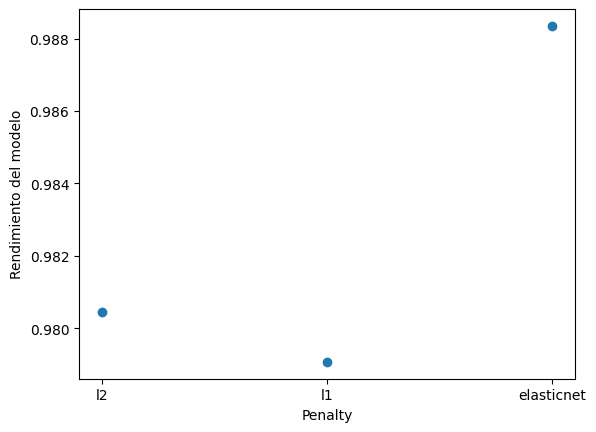

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(penalties, data);
plt.ylabel("Rendimiento del modelo");
plt.xlabel("Penalty");

Para este perceptron tenemos que la mejor penalty es la elasticnet.


### Base de datos 2 (Occupancy)



In [ ]:
penalties = ['l2','l1','elasticnet']
data = []
for penal in penalties: 
  perceptron = Perceptron(penalty=penal,tol=1e-3, fit_intercept=True, random_state=0)
  scores = cross_val_score(perceptron, occupancy_X, occupancy_Y, cv=100)
  data.append(scores.mean())

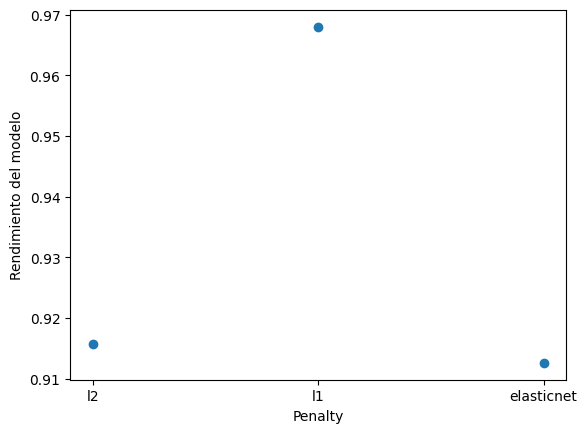

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(penalties, data);
plt.ylabel("Rendimiento del modelo");
plt.xlabel("Penalty");

Para este perceptron tenemos que la mejor penalty es la l1

## SVM

En este caso, los datos ya han sido procesados de tal manera que nuestro modelo de SVM puede utilizarlos. Ahora, vamos a probar diversos kernels para encontrar el mejor modelo que se ajuste a esta información. El objetivo es determinar qué kernel proporciona el mejor rendimiento para nuestro modelo SVM.

### Base de datos 1 (Banknotes)


In [ ]:
from sklearn.svm import SVC

kernels = ['linear','poly','rbf']
data = []
for kernel in kernels: 
  svc = SVC(kernel=kernel)
  scores = cross_val_score(svc, X_data_bank, y_data_bank, cv=10)
  data.append(scores.mean())

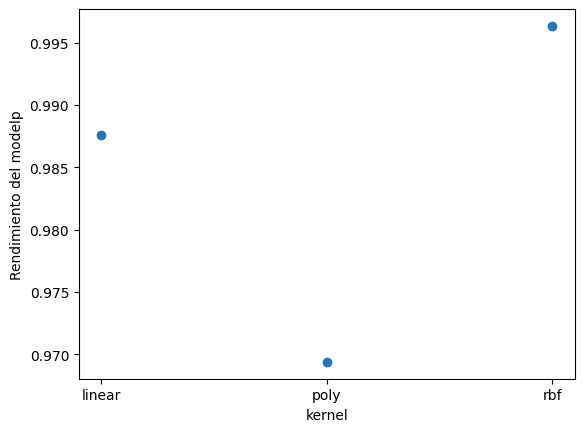

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(kernels, data);
plt.ylabel("Rendimiento del modelp");
plt.xlabel("kernel");

### Base de datos 2 (Occupancy)

In [ ]:
from sklearn.svm import SVC

# Modelo
kernels = ['linear','poly','rbf']
data = []

for kernel in kernels: 
  svc = SVC(kernel=kernel)
  scores = cross_val_score(svc,occupancy_X, occupancy_Y, cv=5)
  data.append(scores.mean())


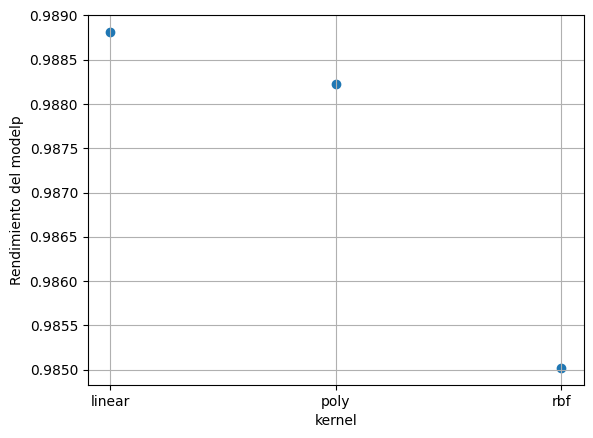

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(kernels, data);
plt.ylabel("Rendimiento del modelp");
plt.xlabel("kernel");
plt.grid(True);

## KNN

En este caso, los datos ya han sido procesados de tal manera que nuestro modelo de KNN pueda utilizarlos. Ahora, vamos a determinar la cantidad adecuada de vecinos (neighbors) para que nuestro modelo funcione de manera óptima.

### Base de datos 1 (Banknotes)
Para esta base de datos vamos a usar KNN, y vamos a ver cuál es la cantidad más acertada de neigborns para que nustro modelo tenga mejor desepeño

In [ ]:
max_neighbors = 100
 
data = [] 
for neighbors in range(1, max_neighbors): 
  knn = KNeighborsClassifier(neighbors)
  scores = cross_val_score(knn, X_data_bank, y_data_bank, cv=20)
  data.append(scores.mean())

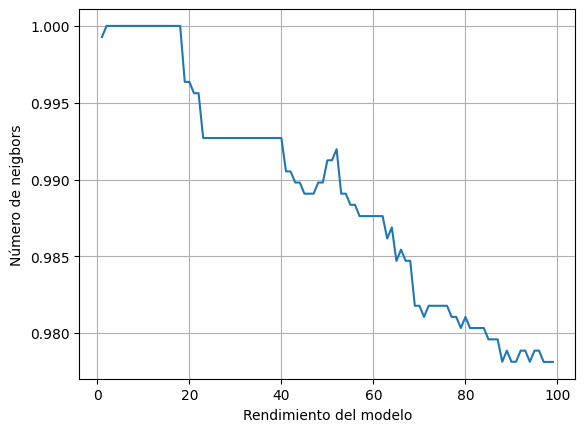

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,max_neighbors), data);
plt.ylabel("Número de neigbors");
plt.xlabel("Rendimiento del modelo");
plt.grid(True);

En este caso, podemos observar que la cantidad de vecinos (neighbors) no debe ser muy alta. Por lo tanto, podemos establecer que utilizando de 5 a 9 vecinos obtendremos el mejor desempeño para nuestro modelo.


### Base de datos 2 (Occupancy)

Para esta base de datos, vamos a utilizar el algoritmo KNN (K-Nearest Neighbors) y vamos a explorar diferentes hiperparámetros para mejorar el rendimiento de nuestro modelo. En particular, vamos a probar con diferentes cantidades de vecinos (neigbors) para determinar cuál nos proporciona un mejor desempeño.

In [ ]:
max_neighbors = 100
 
data = [] 
for neighbors in range(1, max_neighbors): 
  knn = KNeighborsClassifier(neighbors)
  scores = cross_val_score(knn, occupancy_X,occupancy_Y, cv=20)
  data.append(scores.mean())

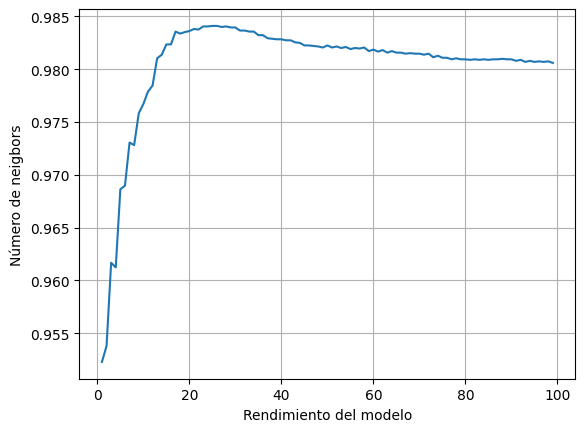

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,max_neighbors), data);
plt.ylabel("Número de neigbors");
plt.xlabel("Rendimiento del modelo");
plt.grid(True);

En este caso, podemos observar que la cantidad de vecinos (neighbors) no debe ser muy alta. Por lo tanto, podemos establecer que utilizando de 20 a 25 vecinos obtendremos el mejor desempeño para nuestro modelo.

## Regresión Logística

En este caso, los datos ya han sido procesados de tal manera que nuestro modelo de regresión logística pueda utilizarlos. En este caso vamos a jugar con algunos hiperparametros y comparar su rendimiento. 


### Base de datos 1 (Banknotes)


In [ ]:
from sklearn.linear_model import LogisticRegression 

data = []
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

for solve in solvers: 
  regresion_logistica = LogisticRegression(solver= solve);
  scores = cross_val_score(regresion_logistica, X_data_bank, y_data_bank,  cv=20);
  data.append(scores.mean());

print(data)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[0.989823103154305, 0.9883738277919862, 0.989823103154305, 0.989823103154305, 0.989823103154305, 0.989823103154305]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


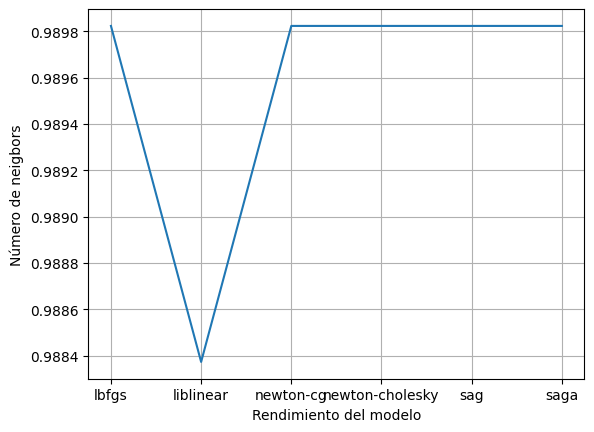

In [ ]:
import matplotlib.pyplot as plt
plt.plot(solvers, data);
plt.ylabel("Número de neigbors");
plt.xlabel("Rendimiento del modelo");
plt.grid(True);

En este caso vemos que el rendimiento usando diversos solvers no cambia mucho

### Base de datos 2 (Occupancy)



In [ ]:
from sklearn.linear_model import LogisticRegression 


data = []
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

for solve in solvers: 
  regresion_logistica = LogisticRegression(solver= solve);
  scores = cross_val_score(regresion_logistica, occupancy_X,occupancy_Y, cv=20)
  data.append(scores.mean());


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached 

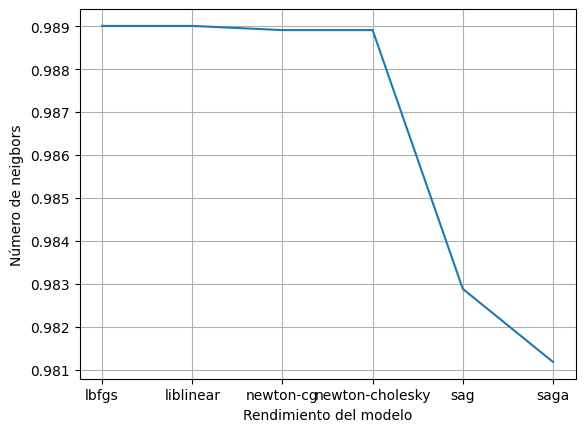

In [ ]:
import matplotlib.pyplot as plt
plt.plot(solvers, data);
plt.ylabel("Número de neigbors");
plt.xlabel("Rendimiento del modelo");
plt.grid(True);

En este caso vemos que el rendimiento usando diversos solvers no cambia mucho